
.. redirect-from:: /tutorials/introductory/animation_tutorial


# Animations using Matplotlib

Based on its plotting functionality, Matplotlib also provides an interface to
generate animations using the `~matplotlib.animation` module. An
animation is a sequence of frames where each frame corresponds to a plot on a
`~matplotlib.figure.Figure`. This tutorial covers a general guideline on
how to create such animations and the different options available.  More information is available in the API description: `~matplotlib.animation`


In [7]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

## Animation classes

The animation process in Matplotlib can be thought of in 2 different ways:

- `~matplotlib.animation.FuncAnimation`: Generate data for first
  frame and then modify this data for each frame to create an animated plot.

- `~matplotlib.animation.ArtistAnimation`: Generate a list (iterable)
  of artists that will draw in each frame in the animation.

`~matplotlib.animation.FuncAnimation` is more efficient in terms of
speed and memory as it draws an artist once and then modifies it. On the
other hand `~matplotlib.animation.ArtistAnimation` is flexible as it
allows any iterable of artists to be animated in a sequence.

### ``FuncAnimation``

The `~matplotlib.animation.FuncAnimation` class allows us to create an
animation by passing a function that iteratively modifies the data of a plot.
This is achieved by using the *setter* methods on various
`~matplotlib.artist.Artist` (examples: `~matplotlib.lines.Line2D`,
`~matplotlib.collections.PathCollection`, etc.). A usual
`~matplotlib.animation.FuncAnimation` object takes a
`~matplotlib.figure.Figure` that we want to animate and a function
*func* that modifies the data plotted on the figure. It uses the *frames*
parameter to determine the length of the animation. The *interval* parameter
is used to determine time in milliseconds between drawing of two frames.
Animating using `.FuncAnimation` typically requires these steps:

1) Plot the initial figure as you would in a static plot. Save all the created
   artists, which are returned by the plot functions, in variables so that you can
   access and modify them later in the animation function.
2) Create an animation function that updates the artists for a given frame.
   Typically, this calls ``set_*`` methods of the artists.
3) Create a `.FuncAnimation`, passing the `.Figure` and the animation function.
4) Save or show the animation using one of the following methods:

   - `.pyplot.show` to show the animation in a window
   - `.Animation.to_html5_video` to create a HTML ``<video>`` tag
   - `.Animation.to_jshtml` to create HTML code with interactive JavaScript animation
     controls
   - `.Animation.save` to save the animation to a file

The following table shows a few plotting methods, the artists they return and some
commonly used ``set_*`` methods that update the underlying data. While updating data
is the most common operation in animations, you can also update other aspects such as
color or text position.

========================================  =============================  ===========================
Plotting method                           Artist                         Data set methods
========================================  =============================  ===========================
`.Axes.plot`                              `.lines.Line2D`                `~.Line2D.set_data`,
                                                                         `~.Line2D.set_xdata`,
                                                                         `~.Line2D.set_ydata`
`.Axes.scatter`                           `.collections.PathCollection`  `~.collections.\
                                                                         PathCollection.set_offsets`
`.Axes.imshow`                            `.image.AxesImage`             ``AxesImage.set_data``
`.Axes.annotate`                          `.text.Annotation`             `~.text.Annotation.\
                                                                         update_positions`
`.Axes.barh`                              `.patches.Rectangle`           `~.Rectangle.set_angle`,
                                                                         `~.Rectangle.set_bounds`,
                                                                         `~.Rectangle.set_height`,
                                                                         `~.Rectangle.set_width`,
                                                                         `~.Rectangle.set_x`,
                                                                         `~.Rectangle.set_y`,
                                                                         `~.Rectangle.set_xy`
`.Axes.fill`                              `.patches.Polygon`             `~.Polygon.set_xy`
`.Axes.add_patch`\(`.patches.Ellipse`\)   `.patches.Ellipse`             `~.Ellipse.set_angle`,
                                                                         `~.Ellipse.set_center`,
                                                                         `~.Ellipse.set_height`,
                                                                         `~.Ellipse.set_width`
`.Axes.set_title`, `.Axes.text`           `.text.Text`                   `~.Text.set_text`
========================================  =============================  ===========================

Covering the set methods for all types of artists is beyond the scope of this
tutorial but can be found in their respective documentations. An example of
such update methods in use for `.Axes.scatter` and `.Axes.plot` is as follows.



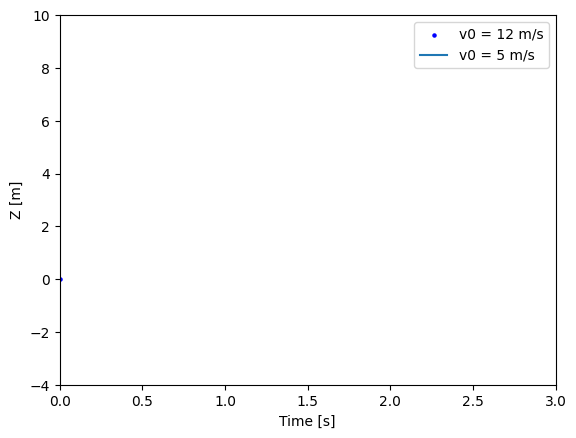

In [8]:
fig, ax = plt.subplots()
t = np.linspace(0, 3, 40)
g = -9.81
v0 = 12
z = g * t**2 / 2 + v0 * t

v02 = 5
z2 = g * t**2 / 2 + v02 * t

scat = ax.scatter(t[0], z[0], c="b", s=5, label=f'v0 = {v0} m/s')
line2 = ax.plot(t[0], z2[0], label=f'v0 = {v02} m/s')[0]
ax.set(xlim=[0, 3], ylim=[-4, 10], xlabel='Time [s]', ylabel='Z [m]')
ax.legend()


def update(frame):
    # for each frame, update the data stored on each artist.
    x = t[:frame]
    y = z[:frame]
    # update the scatter plot:
    data = np.stack([x, y]).T
    scat.set_offsets(data)
    # update the line plot:
    line2.set_xdata(t[:frame])
    line2.set_ydata(z2[:frame])
    return (scat, line2)


ani = animation.FuncAnimation(fig=fig, func=update, frames=40, interval=30)
plt.show()

### ``ArtistAnimation``

`~matplotlib.animation.ArtistAnimation` can be used
to generate animations if there is data stored on various different artists.
This list of artists is then converted frame by frame into an animation. For
example, when we use `.Axes.barh` to plot a bar-chart, it creates a number of
artists for each of the bar and error bars. To update the plot, one would
need to update each of the bars from the container individually and redraw
them. Instead, `.animation.ArtistAnimation` can be used to plot each frame
individually and then stitched together to form an animation. A barchart race
is a simple example for this.



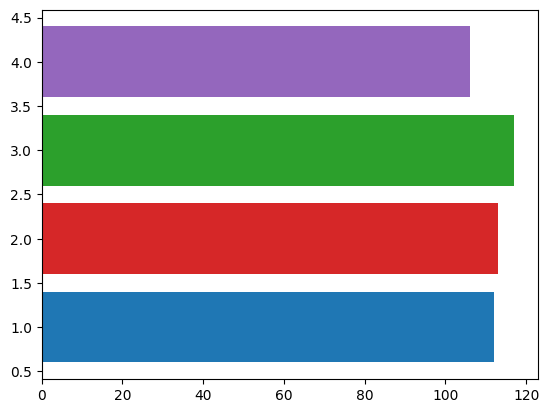

In [9]:
fig, ax = plt.subplots()
rng = np.random.default_rng(19680801)
data = np.array([20, 20, 20, 20])
x = np.array([1, 2, 3, 4])

artists = []
colors = ['tab:blue', 'tab:red', 'tab:green', 'tab:purple']
for i in range(20):
    data += rng.integers(low=0, high=10, size=data.shape)
    container = ax.barh(x, data, color=colors)
    artists.append(container)


ani = animation.ArtistAnimation(fig=fig, artists=artists, interval=400)
plt.show()

## Animation writers

Animation objects can be saved to disk using various multimedia writers
(ex: Pillow, *ffpmeg*, *imagemagick*). Not all video formats are supported
by all writers. There are 4 major types of writers:

- `~matplotlib.animation.PillowWriter` - Uses the Pillow library to
  create the animation.

- `~matplotlib.animation.HTMLWriter` - Used to create JavaScript-based
  animations.

- Pipe-based writers - `~matplotlib.animation.FFMpegWriter` and
  `~matplotlib.animation.ImageMagickWriter` are pipe based writers.
  These writers pipe each frame to the utility (*ffmpeg* / *imagemagick*)
  which then stitches all of them together to create the animation.

- File-based writers - `~matplotlib.animation.FFMpegFileWriter` and
  `~matplotlib.animation.ImageMagickFileWriter` are examples of
  file-based writers. These writers are slower than their pipe-based
  alternatives but are more useful for debugging as they save each frame in
  a file before stitching them together into an animation.

### Saving Animations

.. list-table::
   :header-rows: 1

   * - Writer
     - Supported Formats
   * - `~matplotlib.animation.PillowWriter`
     - .gif, .apng, .webp
   * - `~matplotlib.animation.HTMLWriter`
     - .htm, .html, .png
   * - | `~matplotlib.animation.FFMpegWriter`
       | `~matplotlib.animation.FFMpegFileWriter`
     - All formats supported by |ffmpeg|_: ``ffmpeg -formats``
   * - | `~matplotlib.animation.ImageMagickWriter`
       | `~matplotlib.animation.ImageMagickFileWriter`
     - All formats supported by |imagemagick|_: ``magick -list format``

.. |ffmpeg| replace:: *ffmpeg*

.. |imagemagick| replace:: *imagemagick*

To save animations using any of the writers, we can use the
`.animation.Animation.save` method. It takes the *filename* that we want to
save the animation as and the *writer*, which is either a string or a writer
object. It also takes an *fps* argument. This argument is different than the
*interval* argument that `~.animation.FuncAnimation` or
`~.animation.ArtistAnimation` uses. *fps* determines the frame rate that the
**saved** animation uses, whereas *interval* determines the frame rate that
the **displayed** animation uses.

Below are a few examples that show how to save an animation with different
writers.


Pillow writers::

  ani.save(filename="/tmp/pillow_example.gif", writer="pillow")
  ani.save(filename="/tmp/pillow_example.apng", writer="pillow")

HTML writers::

  ani.save(filename="/tmp/html_example.html", writer="html")
  ani.save(filename="/tmp/html_example.htm", writer="html")
  ani.save(filename="/tmp/html_example.png", writer="html")

FFMpegWriter::

  ani.save(filename="/tmp/ffmpeg_example.mkv", writer="ffmpeg")
  ani.save(filename="/tmp/ffmpeg_example.mp4", writer="ffmpeg")
  ani.save(filename="/tmp/ffmpeg_example.mjpeg", writer="ffmpeg")

Imagemagick writers::

  ani.save(filename="/tmp/imagemagick_example.gif", writer="imagemagick")
  ani.save(filename="/tmp/imagemagick_example.webp", writer="imagemagick")
  ani.save(filename="apng:/tmp/imagemagick_example.apng",
           writer="imagemagick", extra_args=["-quality", "100"])

(the ``extra_args`` for *apng* are needed to reduce filesize by ~10x)

Note that *ffmpeg* and *imagemagick* need to be separately installed.
A cross-platform way to obtain *ffmpeg* is to install the ``imageio_ffmpeg``
PyPI package, and then to set
``rcParams["animation.ffmpeg_path"] = imageio_ffmpeg.get_ffmpeg_exe()``.

